<a href="https://colab.research.google.com/github/yudhiesh/corise-Personalized-Recommendations-at-Scale/blob/master/week4_evaluation_yudhiesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U --quiet swifter[groupby]==1.3.2

     |████████████████████████████████| 825 kB 7.8 MB/s 


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import dcg_score,ndcg_score
from collections import OrderedDict
import swifter

# **Welcome to week 4 project!**

Welcome to the last week of the course -- so excited to see that you've made it to the end! 👏 

We’ve already discussed the importance of measuring model performance. As Lord Kelvin said, “To measure is to know – If you cannot measure it, you cannot improve it.” And he was right – metrics are the only way we can actually evaluate our model’s performance!

In this week's project, we will touch upon two key aspects related to evaluation:
1. Behavioral metrics
2. Off-policy evaluation

For behavioral metrics, we will work with Spotify music sessions dataset, and implement a few behavioral metrics and understand their relationships with traditional metrics.

For off-policy evaluation, we will simulate a dataset where we have logged action policies, and see how IPS is implemented.


### Goals for this week's project:

For this week's project assignment, we will complete the following tasks:
1. Implement 3 behavioral metrics and present the correlation plot for them
2. Implement another ranking logic (e.g. sort by track popularity, or sort by danceability and compare all metrics on productional ranking logic and this new ranking logic.
3. Complete the implementation of two off-policy estimators: Capped IPS and Normalized Capped Importance Sampling (NCIS)


# Part A: Behavioral metrics

Behavioral metrics include factors like what items a user interacts with and how, the amount of time they spend on the platform, and how they spend that time.

To define and implement a few behavioral metrics, we will work with the Spotify music sessions dataset.
Download the dataset from GDrive: https://drive.google.com/drive/folders/10LGZMgXRuz2qPr_QDbYdVVlKEcnQ25YL?usp=sharing
(files: log_mini.cvs and tf_mini.csv)

## Spotify music sessions dataset

The public part of the dataset consists of roughly 130 million listening sessions with associated user interactions on the Spotify service. In total, users interacted with almost 4 million tracks during these sessions, and the dataset includes acoustic features and metadata for all of these tracks.

Detailed description of the dataset can be found here:
https://drive.google.com/file/d/1BELTuH4nBeyHna5EAGzJv-HWHKrbxPsf/view?usp=sharing



In [ ]:
!gdown --folder https://drive.google.com/drive/folders/10LGZMgXRuz2qPr_QDbYdVVlKEcnQ25YL?usp=sharing -O ./

Retrieving folder list
Processing file 1_jFxa2s7ONQ7nrhqFc1lARP6WChs2T4e data1.txt
Processing file 1rEJFi98sLUTYj50Fh8ff33A7NKOoT87c hmdata.zip
Processing file 1D3RyRBKBaw0KbLxpJUQDjVIt5CLpE2n9 log_mini.csv
Processing file 1BELTuH4nBeyHna5EAGzJv-HWHKrbxPsf Spotify-dataset-description.pdf
Processing file 1Z8N0Xf9M34PuN4V5G5uAxasvOCm6TVp4 tf_mini.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1_jFxa2s7ONQ7nrhqFc1lARP6WChs2T4e
To: /content/data/data1.txt
100% 158M/158M [00:01<00:00, 126MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rEJFi98sLUTYj50Fh8ff33A7NKOoT87c
To: /content/data/hmdata.zip
100% 773M/773M [00:07<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D3RyRBKBaw0KbLxpJUQDjVIt5CLpE2n9
To: /content/data/log_mini.csv
100% 28.9M/28.9M [00:00<00:00, 122MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1BELTuH4nBeyHna5EAGzJv-HWHKrbxPsf

In [ ]:
log = pd.read_csv("/content/data/log_mini.csv", parse_dates=['date'])
tracks = pd.read_csv("/content/data/tf_mini.csv")

In [ ]:
log.head(2)

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


In [ ]:
tracks.head(2)

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4,0.935512,-0.033284,-0.411896,-0.02858,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3,0.359675,0.145703,-0.850372,0.12386,0.746904,0.371803,-0.420558,-0.213120,-0.525795


### Traditional metrics: ndcg@k

We will use the log dataframe as the main dataframe for evaluation of metrics. The skip_1 flag can be used as a relevance signal -- if the user found the recommendation relevant, skip_1 = False. With this relevance signal, we can compute simple ndcg metrics -- one for each session and then averaged across all sessions. This will serve as a base metric for comparison.

Note: the ranking logic here is assumed to be the production ranker, i.e. sorting by session_position gives the exact order of tracks the Spotify ranker presented to the user.

Lets compute simple skip rate and ndcg metric for the production ranker:

In [ ]:
topk = 10

skip_rate_session = log.groupby('session_id').apply(lambda x: x.nsmallest(topk,['session_position'])).reset_index(drop = True).groupby("session_id").skip_1.mean().mean()
print("average skip rate in the session: ",skip_rate_session)

average skip rate in the session:  0.43395270270270264


In [ ]:
topk = 10

def get_ndcg(df):
    true_relevance = np.asarray(1-np.asarray(df['skip_1']*1.0))
    ranker_scores = np.asarray(1/np.asarray(df['session_position'])) # approximate the ranker scores using the session position
    return(ndcg_score([true_relevance], [ranker_scores]))


ndcg_metric = log.groupby('session_id').apply(lambda x: x.nsmallest(topk,['session_position'])).reset_index(drop = True).groupby("session_id").apply(get_ndcg).mean()
print("NDCG@k, with k= ",topk," is: ",ndcg_metric)

NDCG@k, with k=  10  is:  0.8330266041453142


## Goals for this week:

Implement a few behavioral metrics and compare their correlations. We will implement the following three metrics:
1. *Time to first skip:* how long did it take for the user to get the first bad recommendation, i.e. a recommendation they skipped. Since we can't easily calculate time, we can use number of songs as a proxy and compute the metric as number of songs it took for the first skip.

2. *Sustained dissatisfaction:* we assume that the user is dissatisfied in a sustained manner if they skip 3 songs consecutively.

3. *Session coherence:* we define coherence as how similar the recommended musical tracks are. We can use the acoustic_vector of the music tracks to calculate the similarity.

In [ ]:
# implement session metric 1: time to first skip (number of songs to first skip)


def time_to_first_skip(df: pd.DataFrame, k: int = 5) -> pd.DataFrame:
  return (df
      .query(f"skip_1 == True & session_position <= {k}")
      .groupby(["session_id"])
      .agg({"session_position":min})["session_position"]
      .to_frame(name='time_first_skip')
  )

  

time_to_first_skip_df = time_to_first_skip(log)
time_to_first_skip_df.sample(10)

,time_first_skip
session_id,
0_0975e26f-22c7-42c6-8a1e-b700f892bb98,1
0_0c850a25-be2a-48b1-a316-6e5a2ffd8099,5
0_0df6b7d4-fd28-4cdc-bd6b-cb8261657406,1
0_02a03c02-bad6-4df2-9ed6-6701b4cce83d,2
0_082f1d73-7f34-4719-adc1-9c14a433f01f,1
0_02019093-7a61-4e78-8075-65098b9cb7c0,4
0_09a03136-ecf6-4886-9961-c163ae262128,2
0_07aa3106-f925-40ff-9cb9-588451453c0b,5
0_0bfcd92d-d00e-4973-9f33-3da136b334a7,1


In [ ]:
time_to_first_skip_df.time_first_skip.mean()

2.3261474269819193

In [ ]:
# implement session metric 2: sustained dissatisfaction: proportions of sessions with 3 consecutive skips
def sustained_dissatisfaction(df: pd.DataFrame, consecutive_skips: int = 3) -> pd.DataFrame:
  # Check whether within a particular session with max(session_position) == consecutive_skips 
  # if the sum of values == consecutive_skips(convert skip_1 to int)
  # if its the same then its classified as sustained dissatisfaction
  return (df
    .replace({False: 0, True: 1})
    .query(f"session_position <= {consecutive_skips}")
    .dropna()
    .groupby(['session_id'])['skip_1']
    .sum()
    .to_frame(name="num_skips")
    .assign(dissatisfaction_sustained=lambda df_: np.where(df_.num_skips == consecutive_skips, 1, 0))
    .drop('num_skips', axis=1)
  )

sustained_dissatisfaction_df = sustained_dissatisfaction(log)
sustained_dissatisfaction_df.sample(10)

,dissatisfaction_sustained
session_id,
0_08953569-f58c-454e-a3e6-2de912ba8290,0
0_0c12f8c3-8048-461d-8e71-c81cd6562150,0
0_0b58a9dd-aa40-4d78-93ce-eac74723c6cc,0
0_0c2665e2-53c6-4103-98e0-bece76ac1875,0
0_0c777648-41f3-4f71-ab05-c82b78b6f14e,0
0_012a5d2f-8472-4fa5-918c-0f115c2eb246,0
0_077cfc53-5f83-476a-8d15-addc5c3d0a24,0
0_06fb3fba-f17d-4da1-8f22-d1d50a62cd4c,0
0_06e2e1e2-c67d-42d4-b0cc-13eabc99814a,0


In [ ]:
# implement session metric 3: session coherence: average similarity between the top recommended tracks
def session_coherence(log: pd.DataFrame, tracks: pd.DataFrame, k: int = 5) -> pd.DataFrame:
  # Session coherence can be derived by comparing the 
  # mean of the top k recommended songs vector
  # vs 
  # the mean vector of songs within a session
  # using the dot product

  top_k_tracks = (log
    .track_id_clean
    .value_counts()
    .head(k)
    .index
    .tolist()
  )
  acoustic_vector_columns = tracks.filter(like='acoustic_vector_').columns.tolist()
  avg_top_k_recommended_track_vector = tracks[tracks.track_id.isin(top_k_tracks)][acoustic_vector_columns].mean().values
  session_mean_acoustic_vector_df = (log
    .merge(tracks, how="inner", left_on = "track_id_clean", right_on="track_id")
    .query(f"session_position <= {k}")
    .groupby('session_id')[acoustic_vector_columns]
    .mean()
  )
  def pairwise_comparison(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the dot product between a sessions mean acoustic vector 
    and the mean top k recommended songs in all sessions acoustic vector
    """
    return pd.DataFrame({'session_coherence': np.dot(df.values, avg_top_k_recommended_track_vector)})

  return (session_mean_acoustic_vector_df
    .groupby(['session_id'])[acoustic_vector_columns]
    .apply(lambda df: pairwise_comparison(df))
    .reset_index()
    .drop('level_1', axis=1)
  )

session_coherence_df = session_coherence(log,tracks)
session_coherence_df.head()

,session_id,session_coherence
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1.118177
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,-0.097136
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,1.134913
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.216494
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.326948


In [ ]:
def get_ndcg_session_id_score_k(df, k=5):
  return(df
   .swifter
   .groupby('session_id')
   .apply(lambda x: x.nsmallest(5,['session_position']))
   .reset_index(drop = True)
   .groupby("session_id")
   .apply(get_ndcg)
   .to_frame(name="ndcg")
  )

Once these metrics are implemented, compute these metrics for topk=5 and topk=10 compare their estimates for the production ranker as a correlation plot. Please note which metrics are correlated with ndcg metric.

**Additional goal:**
Implement another simple ranking logic, and compare the performance of both the production ranker and new ranking policy on the ndcg and three behavioral metrics.
A simple ranking policy could include sortby track popularity, or sort by danceability score for the track.

Please report the performance of these rankers on all four metrics.

In [ ]:
ndcg_metric_5 = get_ndcg_session_id_score_k(log)
ndcg_metric_10 = get_ndcg_session_id_score_k(log, 10)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
from functools import reduce

def combine_metrics(*dfs):
  return reduce(lambda left,right: pd.merge(left,right,on='session_id'), dfs)

In [ ]:
metrics_df = combine_metrics(*[ndcg_metric_5, time_to_first_skip_df, sustained_dissatisfaction_df, session_coherence_df])
metrics_df.head()

,session_id,ndcg,time_first_skip,dissatisfaction_sustained,session_coherence
0,0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.904717,2,0,-0.097136
1,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0.885460,2,0,1.134913
2,0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.000000,1,1,0.216494
3,0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.982892,4,0,0.326948
4,0_0002fbb5-29c2-4d54-9636-e6d15e77b58c,0.501266,1,1,0.073085


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation(df, title, cmap="YlGnBu"):
  plt.figure(figsize=(8, 8))
  corr = df.corr()
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, annot=True).set_title(title, fontdict={'fontsize':12}, pad=12)


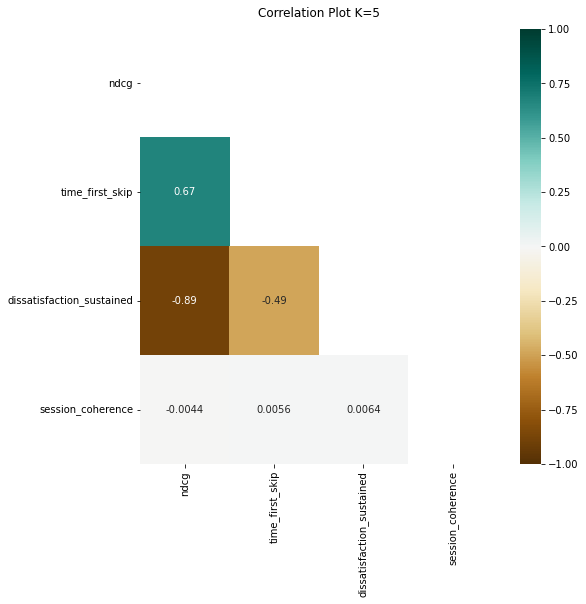

In [ ]:
plot_correlation(metrics_df, title="Correlation Plot K=5", cmap="BrBG")

In [ ]:
k = 10
_time_to_first_skip_df = time_to_first_skip(log, k=k)
_sustained_dissatisfaction_df = sustained_dissatisfaction(log)
_session_coherence_df = session_coherence(log,tracks, k=k)
_metrics_df = combine_metrics(*[ndcg_metric_10, _time_to_first_skip_df, _sustained_dissatisfaction_df, _session_coherence_df])

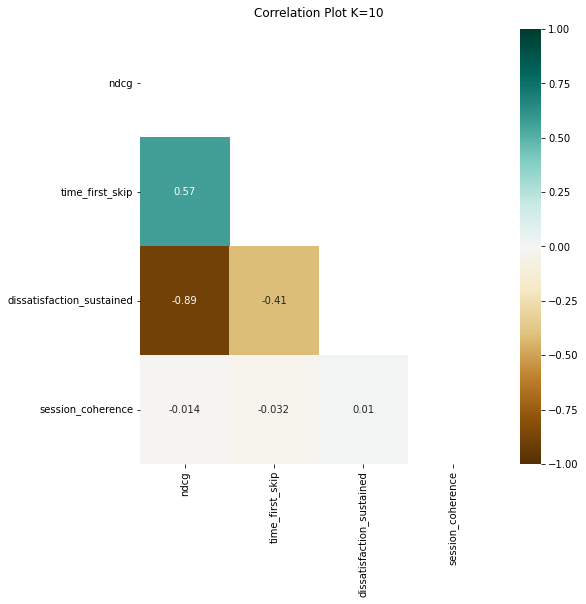

In [ ]:
plot_correlation(_metrics_df, title=f"Correlation Plot K={k}", cmap="BrBG")

# Part B: Off Policy Evaluation

We log listener behavior based on the recommendations that the production recommender serves to the listener. Using this data to assess any new recommender system, however, can present challenges – the production recommender and the new recommender can drastically differ in the results that they display to the user. For example, maybe the new recommender presents a lot of niche content, while the production recommender presents a lot of popular options. This can be an issue when evaluating a new recommender – If you don’t have any feedback on a recommendation because you never presented it to a user, how can you evaluate whether it’s a good recommendation?
If you have a new policy to test that’s very similar to your old approach, then this won’t be an issue, and it’ll be easy to test! However, if the policy is very different, then you’ll need to collect special logged data.

In this part of the project, we will simulate a recommendation policy and leverage counterfactual estimators as metrics to compare performance.


Lets first begin by generating a few users and products. For ease of simulation, we assume users derive equal satisfaction from each item.

In [ ]:

users = np.array(["user1", "user2", "user3"])
products = np.array(
    [
        "product_a",
        "product_b",
        "product_c",
        "product_d",
        "product_e",
        "product_f",
        "product_g",
    ]
)

satisfaction = {
    "product_a": 100,
    "product_b": 150,
    "product_c": 100,
    "product_d": 200,
    "product_e": 500,
    "product_f": 120,
    "product_g": 160,
}



Lets also implement whether a given user will accept a given recommendation or not. Once done, we can implement a target policy that makes recommendations.

In [ ]:

def will_purchase(user, product):
    if user == "user1" and (
        product == "product_a" or product == "product_b" or product == "product_c"
    ):
        return True
    elif user == "user2" and (product == "product_d" or product == "product_e"):
        return True
    elif user == "user3" and (product == "product_f" or product == "product_g"):
        return True
    else:
        return False


def choose_user():
    return np.random.choice(users, size=1)


def logging_policy():
    return np.random.choice(products, size=1), 1 / len(products)


class TargetPolicy:
    def __init__(self):
        self.user_probs = {
            "user1": np.array([0.1, 0.1, 0.2, 0.1, 0.15, 0.15, 0.20]),
            "user2": np.array([0.1, 0.10, 0.05, 0.25, 0.3, 0.1, 0.1]),
            "user3": np.array([0.06, 0.06, 0.3, 0.06, 0.06, 0.4, 0.06]),
        }

        for user, probs in self.user_probs.items():
            assert probs.sum() == 1
            assert len(probs) == len(products)

    def recommend(self, user):
        user_prob = self.user_probs[user]
        product = np.random.choice(products, size=1, p=user_prob)
        product_idx = np.where(products == product)
        prob = user_prob[product_idx]

        return product, prob

    def get_prob(self, user, product):
        user_prob = self.user_probs[user]
        product_idx = np.where(products == product)
        product_prob = user_prob[product_idx]

        return product_prob



Having defined all key components of the dataset generation, lets create logged data that we can finally use for evaluation purposes:

In [ ]:
def compute_satisfaction(user, product):
    if will_purchase(user, product):
        return satisfaction[product.item()]
    else:
        return 0


def create_logs(n=1000):
    logs = []
    target_policy = TargetPolicy()

    for _ in range(n):
        user = choose_user()

        logging_product, logging_prob = logging_policy()
        model_prob = target_policy.get_prob(user.item(), logging_product)

        target_product, _ = target_policy.recommend(user.item())

        logging_satisfaction = compute_satisfaction(user, logging_product)
        target_satisfaction = compute_satisfaction(user, target_product)

        log = OrderedDict(
            {
                "user_features": user.item(),
                "item_placed": logging_product.item(),
                "item_prob": logging_prob,
                "item_satisfaction": logging_satisfaction,
                "model_prob": model_prob.item(),
                "ab_test_satisfaction": target_satisfaction,
            }
        )

        logs.append(log)

    return pd.DataFrame(logs)

Here is what ur logged data now looks like:

In [ ]:
logs = create_logs(n=1000)
logs.head(5)

,user_features,item_placed,item_prob,item_satisfaction,model_prob,ab_test_satisfaction
0,user2,product_f,0.142857,0,0.1,500
1,user1,product_d,0.142857,0,0.1,0
2,user3,product_c,0.142857,0,0.3,120
3,user1,product_g,0.142857,0,0.2,100
4,user1,product_b,0.142857,150,0.1,100


In [ ]:
logs[["user_features", "item_placed", "item_prob", "item_satisfaction"]].sample(n=10)

,user_features,item_placed,item_prob,item_satisfaction
79,user2,product_c,0.142857,0
798,user2,product_a,0.142857,0
660,user2,product_b,0.142857,0
747,user3,product_d,0.142857,0
607,user1,product_g,0.142857,0
410,user1,product_g,0.142857,0
233,user3,product_d,0.142857,0
48,user3,product_g,0.142857,160
373,user2,product_a,0.142857,0
305,user1,product_g,0.142857,0


With all the dataset ready, lets compute the mean rewards (satisfaction) for the logging/production policy and the target policy:

In [ ]:
%%time
sim = create_logs(n=100000)
logging_policy = sim["item_satisfaction"].mean()
target_policy = sim["ab_test_satisfaction"].mean()

print(f"Expected reward from logging policy: {logging_policy: .2f}")
print(f"Expected reward from target policy: {target_policy: .2f}")

Expected reward from logging policy:  63.30
Expected reward from target policy:  100.19
CPU times: user 12.6 s, sys: 531 ms, total: 13.2 s
Wall time: 12.8 s


Now lets implement the IPS estimator:

In [ ]:
def compute_ips(df):
    assert {"model_prob", "item_prob", "item_satisfaction"}.issubset(df.columns)
    return (df["model_prob"] / df["item_prob"] * df["item_satisfaction"]).mean()

In [ ]:
ips_est = compute_ips(logs)
ips_est

96.8212

Computing the IPS estimator on our 1,000 entry log gives an average revenue of 109.34 (very close to the true performance of 100.99) compared with the average revenue of the logging policy of 63.36. Therefore, we should be confident to deploy our target policy to production and do an AB test comparing it with the logging policy as a final validation.

## Goals for this part of project:

Finish the implementation of two additional off-policy estimators:
1. Capped IPS
2. Normalized Capped Importance Sampling (NCIS)

Feel free to try different capping thresholds, and compare the reward and standard deviations of these estimators with the IPS estimator and mean reward.


In [140]:
def compute_capped_ips(df, cap=1000):
  return np.minimum(df['model_prob'] / df['item_prob'] * df["item_satisfaction"], cap).mean()

for i in [1, 10, 100, 1000]:
  print(f"{i}: {compute_capped_ips(logs, i)}")


1: 0.337
10: 3.37
100: 30.5732
1000: 94.62120000000002


In [142]:
def compute_ncis(df, cap=1000):
  capped_probs = np.minimum(df['model_prob'] / df['item_prob'], cap)
  return (capped_probs * df["item_satisfaction"]).mean() / capped_probs.mean()


for i in [1, 10, 100, 1000]:
  print(f"{i}: {compute_ncis(logs, i)}")


1: 74.56946070291018
10: 97.90203850509626
100: 97.90203850509626
1000: 97.90203850509626
